In [155]:
import math
from symbol import parameters

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [3]:
def f(x):
    return 3*x**2 -4*x +5

In [4]:
f(3.0)

20.0

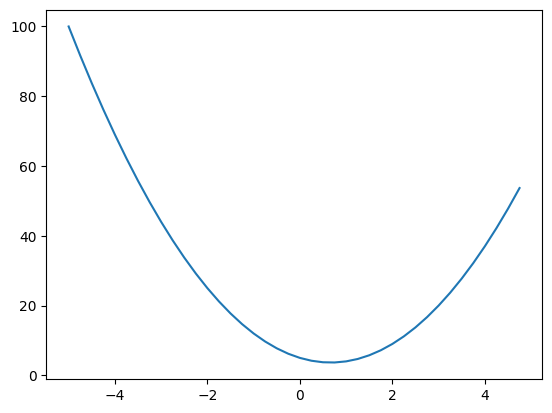

In [5]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h =0.0000000001
x = 3.0
(f(x+h) - f(x))/h

14.000001158365194

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
b+=h
d2 = a*b +c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [207]:
class Value:
    def __init__(self,data,_children = (),_op='',label=''):
        self.grad = 0.0
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self,other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other)

    def __rsub__(self,other):
        return self - other

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1


    def __rmul__(self,other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out


    def backward(self):
        topo =[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [209]:
a = Value(2.0)
b = Value(4.0)
2-a

Value(data=0.0)

In [144]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0,label='f')
L = d *f; L.label='L'
L

Value(data=-8.0)

In [19]:
d._op

'+'

In [20]:
from IPython.display import display, SVG  # For displaying SVG in Jupyter
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    # Create a Digraph object with left-to-right layout
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    # Trace the graph to get all nodes and edges
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # Create a rectangular ('record') node for each value in the graph
        dot.node(name=uid,
                 label="{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad),  # Ensure n.data is a float
                 shape='record')

        if n._op:  # If this value is a result of an operation
            # Create an operation node
            op_name = uid + str(n._op)  # Unique operation node name
            dot.node(name=op_name, label=n._op)
            dot.edge(op_name, uid)  # Connect the op node to the value node

    for n1, n2 in edges:
        # Connect n1 to the operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + (n2._op or ""))

    # Return the dot graph
    return dot


In [27]:
L.grad = 1.0

$$
L = d \cdot f
$$

If \( f \) is independent of \( d \), then:

$$
\frac{dL}{dd} = \frac{d}{dd} (d \cdot f)
$$

Since \( f \) is a constant with respect to \( d \):

$$
\frac{dL}{dd} = f.
$$



In [36]:
f.grad = 4.0
d.grad = -2.0



$$
L = d \cdot f
$$

$$
d = c + e
$$

$$
\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc}
$$

$$
\frac{dL}{de} = \frac{dL}{dd} \cdot \frac{dd}{de}
$$


In [41]:
c.grad = -2.0
e.grad = -2.0

$$
L = d \cdot f
$$

$$
d = c + e
$$

$$
e = a \cdot b
$$

$$
\frac{de}{da} = b
$$

$$
\frac{de}{db} = a
$$

$$
\frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{da}
$$

$$
\frac{dL}{db} = \frac{dL}{de} \cdot \frac{de}{db}
$$


In [48]:
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

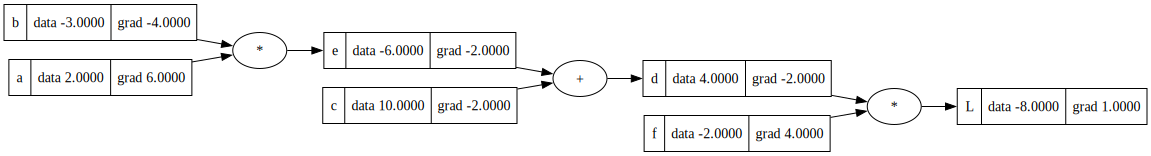

In [49]:
draw_dot(L)

In [52]:
def lol():
    h =0.001
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0,label='f')
    L = d *f; L.label='L'
    L1 = L.data

    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    b.data+=h
    c = Value(10.0,label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0,label='f')
    L = d *f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-3.9999999999995595


In [127]:
#inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias
b = Value(6.8813735870195432,label='b')

x1w1= x1*w1; x1w1.label='x1w1'
x2w2= x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+ x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2+b; n.label='n'
o = n.tanh(); o.label='o'

o = tanh(n)

do/dn = 1 - o^2

In [62]:
1- o.data**2

0.4999999999999999

In [66]:
o.grad = 1.0
n.grad = 0.5

In [68]:
# gradients just flow through + node
x1w1x2w2.grad = 0.5
b.grad=  0.5

In [70]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [72]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

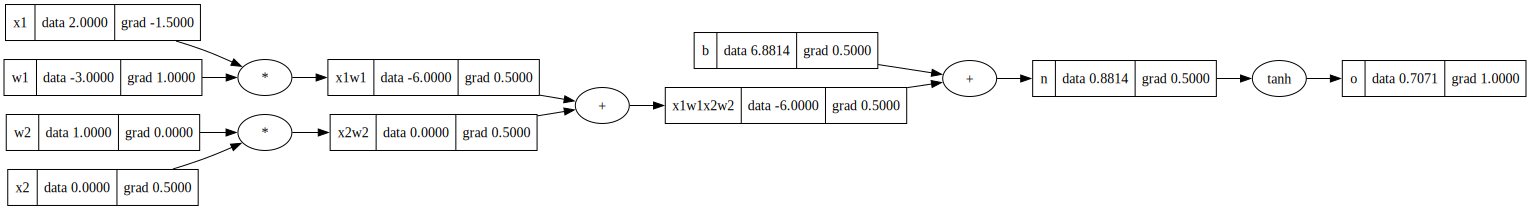

In [130]:
draw_dot(o)

In [129]:
o.backward()

In [86]:

o._backward()

In [88]:
n._backward()

In [90]:
x1w1x2w2._backward()

In [92]:
x2w2._backward()
x1w1._backward()

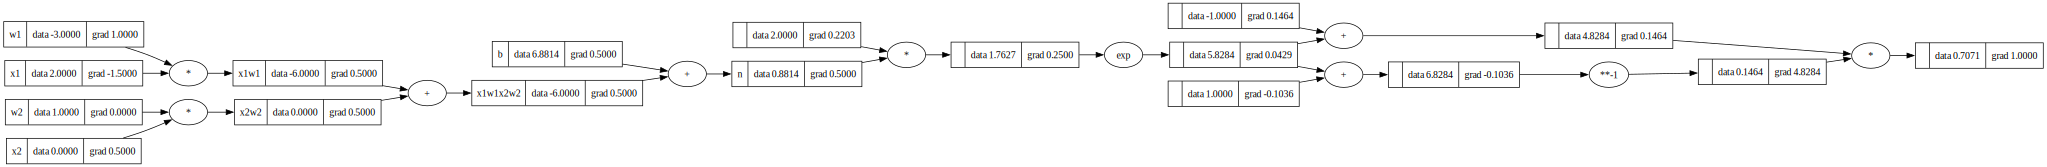

In [154]:
#inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias
b = Value(6.8813735870195432,label='b')

x1w1= x1*w1; x1w1.label='x1w1'
x2w2= x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+ x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2+b; n.label='n'
e = (2*n).exp()
o = (e-1)/(e+1)
o.backward()
draw_dot(o)

In [218]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out

    def params(self):
        return self.w +[self.b]


In [174]:
x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=-0.03292327598980612)

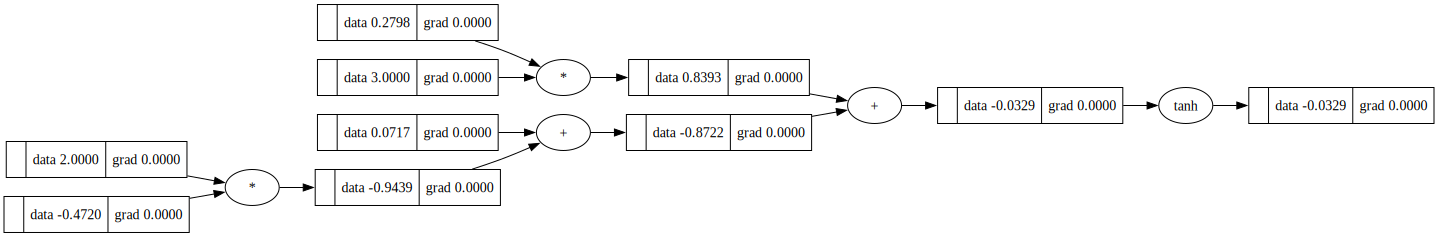

In [175]:
draw_dot(n(x))

In [219]:
class Layer:
    def __init__(self,nin,out):
        self.neurons = [Neuron(nin) for _ in range(out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def params(self):
        return [p for neuron in self.neurons for p in neuron.params()]



In [220]:
n = Layer(2,3)
n(x)

[Value(data=-0.6216394228749738),
 Value(data=-0.9949689385048455),
 Value(data=0.9992100686812192)]

In [322]:
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def params(self):
        return [p for layer in self.layers for p in layer.params()]

In [332]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.6263727457858973)

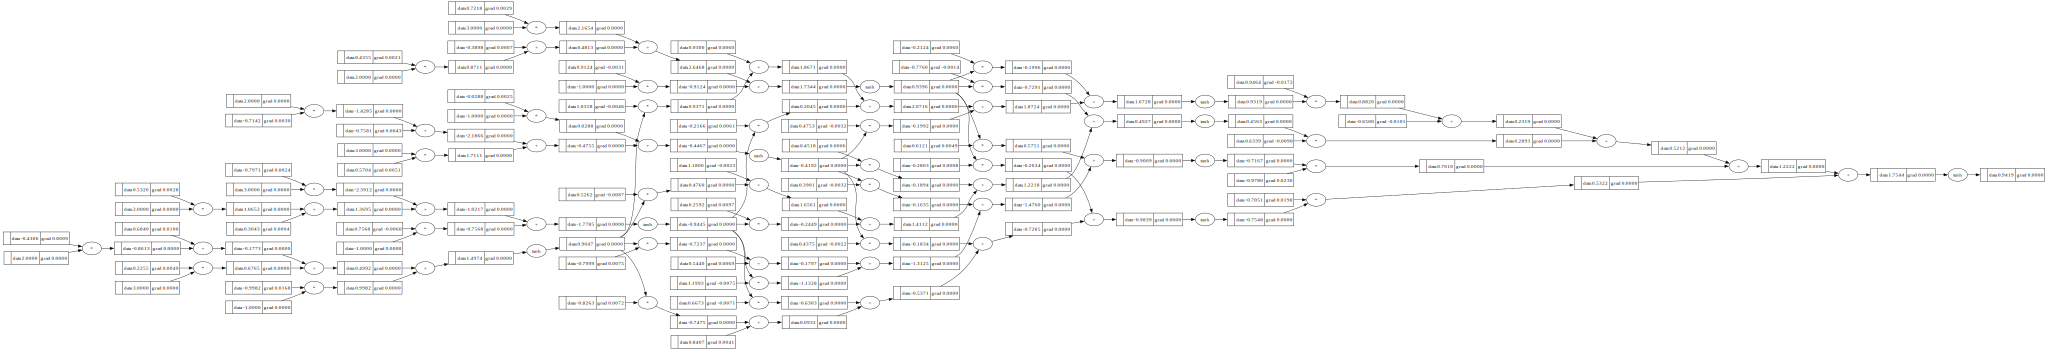

In [337]:
draw_dot(n(x))

In [225]:
len(n.params())

41

In [333]:
xs =[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] # desired targets



In [334]:
for k in range(30):
    # forward pass
    ypred = [n(x) for x in xs]

    # loss calculate
    loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))

    # backprop
    for p in n.params():
        p.grad = 0.0
    loss.backward()

    # update params
    for p in n.params():
        p.data += -0.1 * p.grad

    print(k, loss.data)



0 4.570256766728122
1 3.184605666486944
2 0.6734712839433891
3 0.10068663064142103
4 0.057730314849426756
5 0.044065391323517056
6 0.036284808864788354
7 0.031014323138119797
8 0.02712700491175781
9 0.024112599438811933
10 0.02169599356015424
11 0.019711390168092882
12 0.0180510699451608
13 0.01664121102132575
14 0.01542917530155917
15 0.014376259092947721
16 0.013453294921011596
17 0.012637850707776425
18 0.011912375863697556
19 0.011262934847205329
20 0.010678319027902821
21 0.010149409834192932
22 0.009668713249167004
23 0.00923001380659443
24 0.008828113575054902
25 0.008458632635751598
26 0.008117854741305709
27 0.007802606629553949
28 0.007510162720173585
29 0.007238169172936074


In [335]:
ypred

[Value(data=0.9408303773562272),
 Value(data=-0.9929658443202217),
 Value(data=-0.9523985855284093),
 Value(data=0.9622938874543386)]